# turboPy App: Particle In Field

This notebook shows an example app simulating the motion of a charged particle thorugh an electric field. This app is able to estimate the position, momentum, and electric field over time. 

We will create two custom `PhysicsModule` classes: `EMWave` and `ChargedParticle` which will take care of updating the electric field and the particles position and momentum respectively. 

We first need to make the necessary imports:

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from turbopy import Simulation, PhysicsModule, Diagnostic
from turbopy import CSVOutputUtility, ComputeTool, FieldDiagnostic
from turbopy import construct_simulation_from_toml

Then create subclasses for the `PhysicsModule` and `Diagnostic` classes and override the necessary methods. These classes hold data necessary for the simulation that will be specified later

In [ ]:
class EMWave(PhysicsModule):
    def __init__(self, owner: Simulation, input_data: dict):
        super().__init__(owner, input_data)
        self.c = 2.998e8
        self.E0 = input_data["amplitude"]

        self.E = xr.DataArray(owner.grid.generate_field(),
                              dims="x", coords={"x": owner.grid.r})
        self.E.x.attrs["long_name"] = "Position"
        self.E.x.attrs["units"] = "m"
        self.E.attrs["long_name"] = "Electric Field"
        self.E.attrs["units"] = "V/m"

        self.omega = input_data["omega"]
        self.k = self.omega / self.c
    
    def initialize(self):
        phase = - self.omega * 0 + self.k * (self._owner.grid.r - 0.5)
        self.E[:] = self.E0 * np.cos(2 * np.pi * phase)

    def update(self):
        phase = - self.omega * self._owner.clock.time \
                + self.k * (self._owner.grid.r - 0.5)
        self.E[:] = self.E0 * np.cos(2 * np.pi * phase)
        
    def exchange_resources(self):
        self.publish_resource({"EMField:E": self.E})

In [ ]:
class ChargedParticle(PhysicsModule):
    def __init__(self, owner: Simulation, input_data: dict):
        super().__init__(owner, input_data)
        self.E = None
        self.x = input_data["position"]
        self.interp_field = owner.grid.create_interpolator(self.x)
        self.position = np.zeros((1, 3))
        self.momentum = np.zeros((1, 3))
        self.eoverm = 1.7588e11
        self.charge = 1.6022e-19
        self.mass = 9.1094e-31
        self.push = owner.find_tool_by_name(input_data["pusher"]).push
        
    def exchange_resources(self):
        self.publish_resource({"ChargedParticle:position": self.position})
        self.publish_resource({"ChargedParticle:momentum": self.momentum})
    
    def inspect_resource(self, resource):
        if "EMField:E" in resource:
            self.E = resource["EMField:E"]    

    def update(self):
        E = np.array([0, self.interp_field(self.E), 0])
        self.push(self.position, self.momentum, self.charge, self.mass, E, B=0)

In [ ]:
class ParticleDiagnostic(Diagnostic):
    def __init__(self, owner: Simulation, input_data: dict):
        super().__init__(owner, input_data)
        self.data = None
        self.component = input_data["component"]
        self.output_function = None
        
    def inspect_resource(self, resource):
        if "ChargedParticle:" + self.component in resource:
            self.data = resource["ChargedParticle:" + self.component]
    
    def diagnose(self):
        self.output_function(self.data[0, :])

    def initialize(self):
        # setup output method
        functions = {"stdout": self.print_diagnose,
                     "csv": self.csv_diagnose,
                     }
        self.output_function = functions[self._input_data["output_type"]]
        if self._input_data["output_type"] == "csv":
            diagnostic_size = (self._owner.clock.num_steps + 1, 3)
            self.csv = CSVOutputUtility(self._input_data["filename"], diagnostic_size)

    def finalize(self):
        self.diagnose()
        if self._input_data["output_type"] == "csv":
            self.csv.finalize()

    def print_diagnose(self, data):
        print(data)

    def csv_diagnose(self, data):
        self.csv.append(data)

The `FieldPlottingDiagnostic` is an extension of the `FieldDiagnostic` class under turboPy's pre-registered `Diagnostic` classes.

In [ ]:
class FieldPlottingDiagnostic(FieldDiagnostic):
    """Extend the FieldDiagnostic to also create plots of the data"""
    def __init__(self, owner: Simulation, input_data: dict):
        super().__init__(owner, input_data)

    def do_diagnostic(self):
        super().do_diagnostic()
        plt.clf()
        self.field.plot()
        plt.title(f"Time: {self._owner.clock.time:0.3e} s")
        plt.pause(0.01)

    def finalize(self):
        super().finalize()
        # Call show to keep the plot open
        plt.show()

We create a `ComputeTool` subclass to implement the math behind the simulation. In this case, we will be using the forward euler method, creating a `ForwardEuler` subclass. 

In [ ]:
class ForwardEuler(ComputeTool):
    def __init__(self, owner: Simulation, input_data: dict):
        super().__init__(owner, input_data)
        self.dt = None
        
    def initialize(self):
        self.dt = self._owner.clock.dt
    
    def push(self, position, momentum, charge, mass, E, B):
        p0 = momentum.copy()
        momentum[:] = momentum + self.dt * E * charge
        position[:] = position + self.dt * p0 / mass

To use these classes in our simulation, we need to register them with their respective super classes:

In [ ]:
PhysicsModule.register("EMWave", EMWave)
PhysicsModule.register("ChargedParticle", ChargedParticle)
Diagnostic.register("ParticleDiagnostic", ParticleDiagnostic)
Diagnostic.register("FieldPlottingDiagnostic", FieldPlottingDiagnostic)
ComputeTool.register("ForwardEuler", ForwardEuler)

To set up our `Simulation` class, we pass in a dictionary of input data that we will read from a `.toml` file.

In [ ]:
input_file = "particle_in_field.toml"
sim = construct_simulation_from_toml(input_file)
sim.run()

In [ ]:
# particle_in_field.toml

# Define simulation related parameters
[Grid]
N = 30
r_min = 0.0
r_max = 1.0

[Clock]
start_time = 0.0
end_time = 1e-8
num_steps = 20


# Add the physics modules
[PhysicsModules]         
[PhysicsModules.EMWave]
amplitude = 1.0
omega = 2e8

[PhysicsModules.ChargedParticle]
position = 0.5
pusher = "ForwardEuler"

# Add the compute tools
# Empty "heading" is ok, adds the tool with no/default parameters
[Tools.ForwardEuler]


# Add the diagnostics
[Diagnostics]
# First add some default diagnostic parameters
directory = "output/"
output_type = "csv"

[Diagnostics.grid]
filename = "grid.csv"

[Diagnostics.clock]
filename = "time.csv"

# [[Diagnostics.field]] # Double brackets here because we can have multiples of these...
[[Diagnostics.FieldPlottingDiagnostic]]
component = 0
field = "EMField:E"
filename = "efield.csv"

[Diagnostics.point] # single brackets here because we only have one of these...
field = "EMField:E"
location = 0.5
filename = "e_0.5.csv"

[[Diagnostics.ParticleDiagnostic]]
component = "momentum"
filename = "particle_p.csv"

[[Diagnostics.ParticleDiagnostic]]
component = "position"
filename = "particle_x.csv"

The `Simulation`class's `CSVOutputUtility` outputs data to directory `output/`
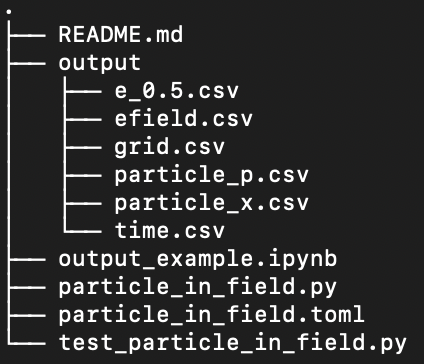

Running the app in termimal: 

In [ ]:
>>> python ./particle_in_field.py

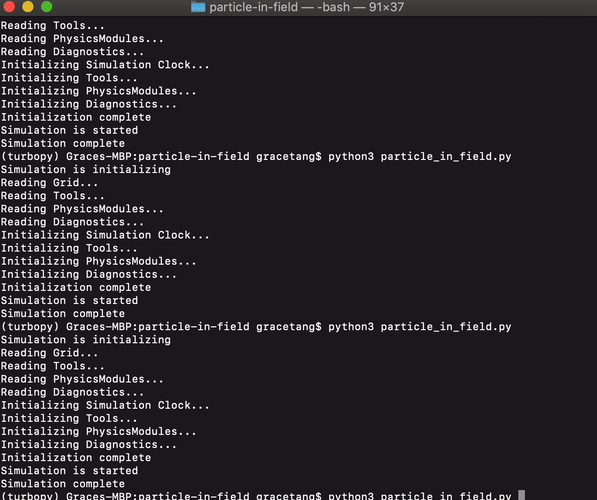

`e_0.5.csv`:      Electromagnetic field at 0.5 \
`efield.csv`:     Electromagnetic field \
`grid.csv`:       Simulation's Grid points \
`particle_p.csv`: Particle momentum \
`particle_x.csv`: Particle position \
`time.csv`:       SimulationClock

## Graphs:

We can plot data with either the output CSV files, or with `CSVOutputUtility`'s `buffer` variable.

In [ ]:
print(sim.diagnostics)

[GridDiagnostic({'directory': 'output/', 'output_type': 'csv', 'filename': 'output/grid.csv', 'type': 'grid'}), ClockDiagnostic({'directory': 'output/', 'output_type': 'csv', 'filename': 'output/time.csv', 'type': 'clock'}), FieldPlottingDiagnostic({'directory': 'output/', 'output_type': 'csv', 'component': 0, 'field': 'EMField:E', 'filename': 'output/efield.csv', 'type': 'FieldPlottingDiagnostic'}), PointDiagnostic({'directory': 'output/', 'output_type': 'csv', 'field': 'EMField:E', 'location': 0.5, 'filename': 'output/e_0.5.csv', 'type': 'point'}), ParticleDiagnostic({'directory': 'output/', 'output_type': 'csv', 'component': 'momentum', 'filename': 'output/particle_p.csv', 'type': 'ParticleDiagnostic'}), ParticleDiagnostic({'directory': 'output/', 'output_type': 'csv', 'component': 'position', 'filename': 'output/particle_x.csv', 'type': 'ParticleDiagnostic'})]

Now we can use the data provided in `buffer` for our plots.


In [ ]:
time = []
momentum = []
position = []
field = []

for i in sim.diagnostics[1].csv.buffer:
    time.append(i[0])

for i in sim.diagnostics[4].csv.buffer:
    momentum.append(i[1])

for i in sim.diagnostics[5].csv.buffer:
    position.append(i[1])

for i in sim.diagnostics[3].csv.buffer:
    field.append(i[0])

plt.plot(time, field)
plt.xlabel('Time')
plt.ylabel('Field')
plt.show()

plt.plot(time, momentum)
plt.xlabel('Time')
plt.ylabel('Momentum')
plt.show()

plt.plot(time, position)
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

plt.plot(position, momentum)
plt.xlabel('Position')
plt.ylabel('Momentum')
plt.show()

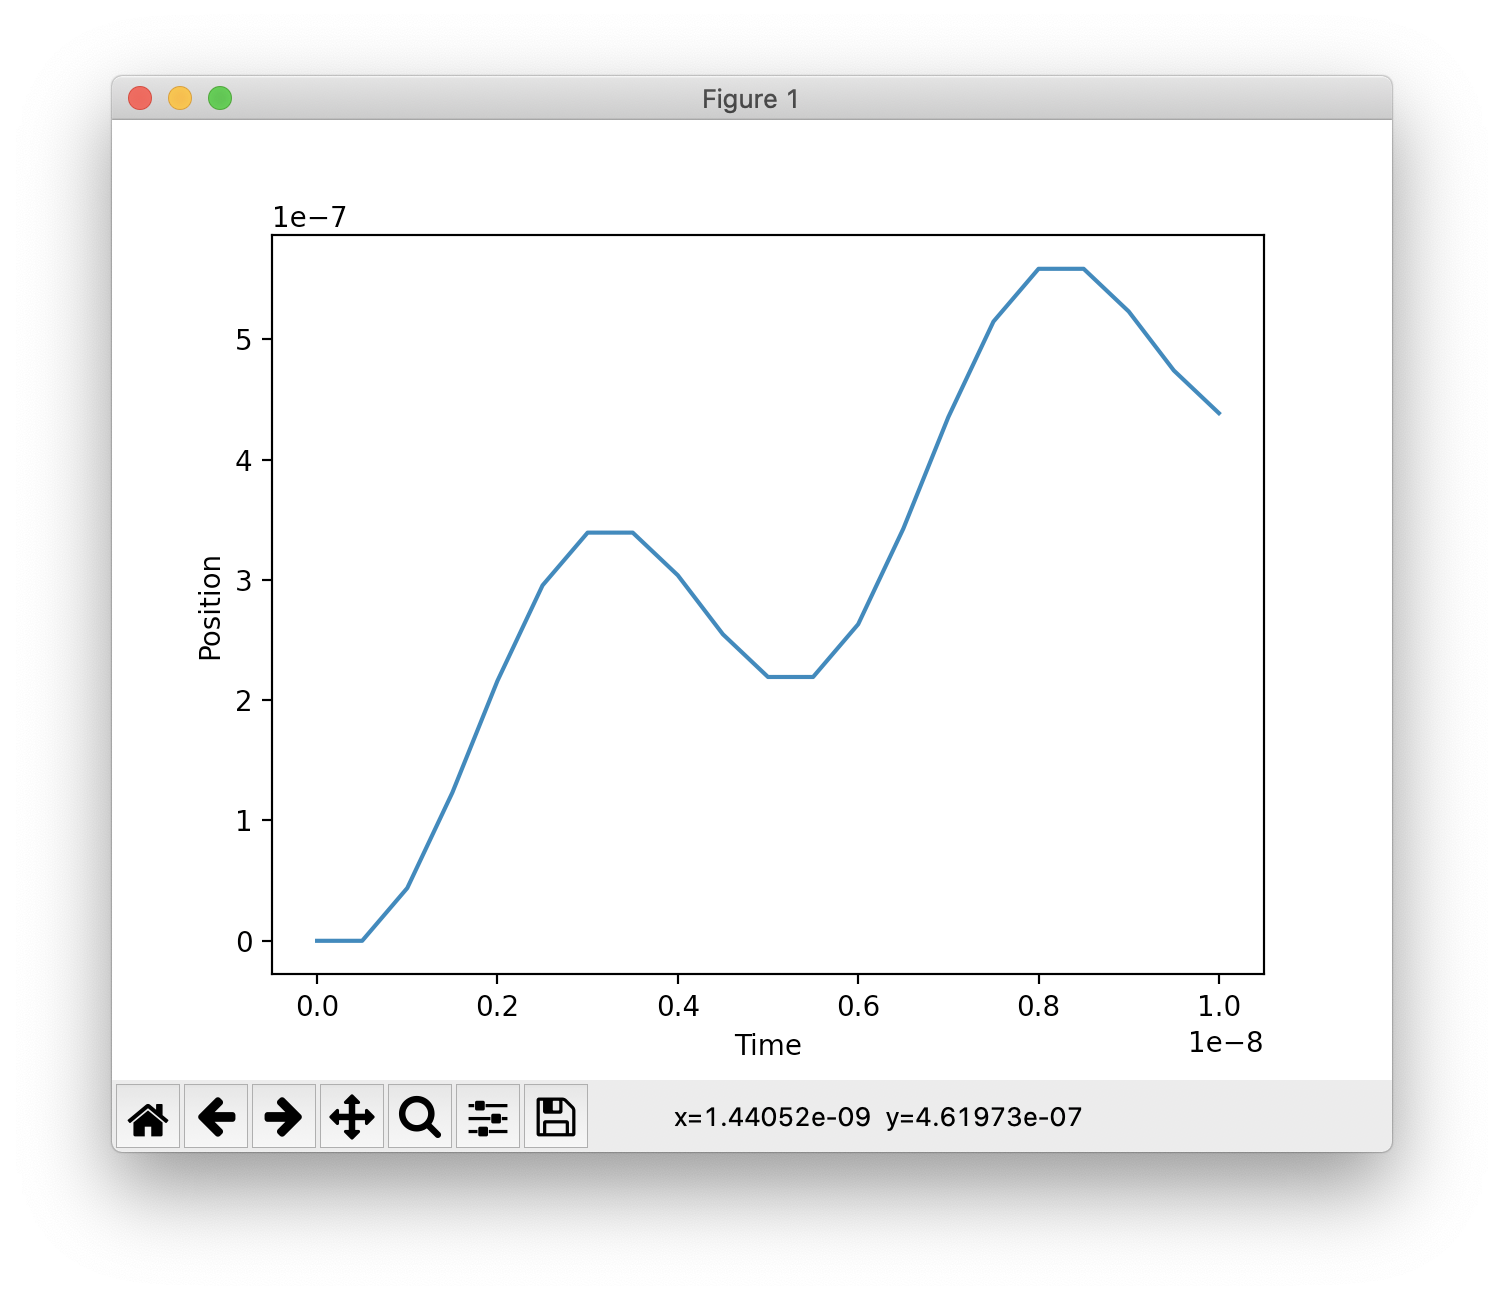

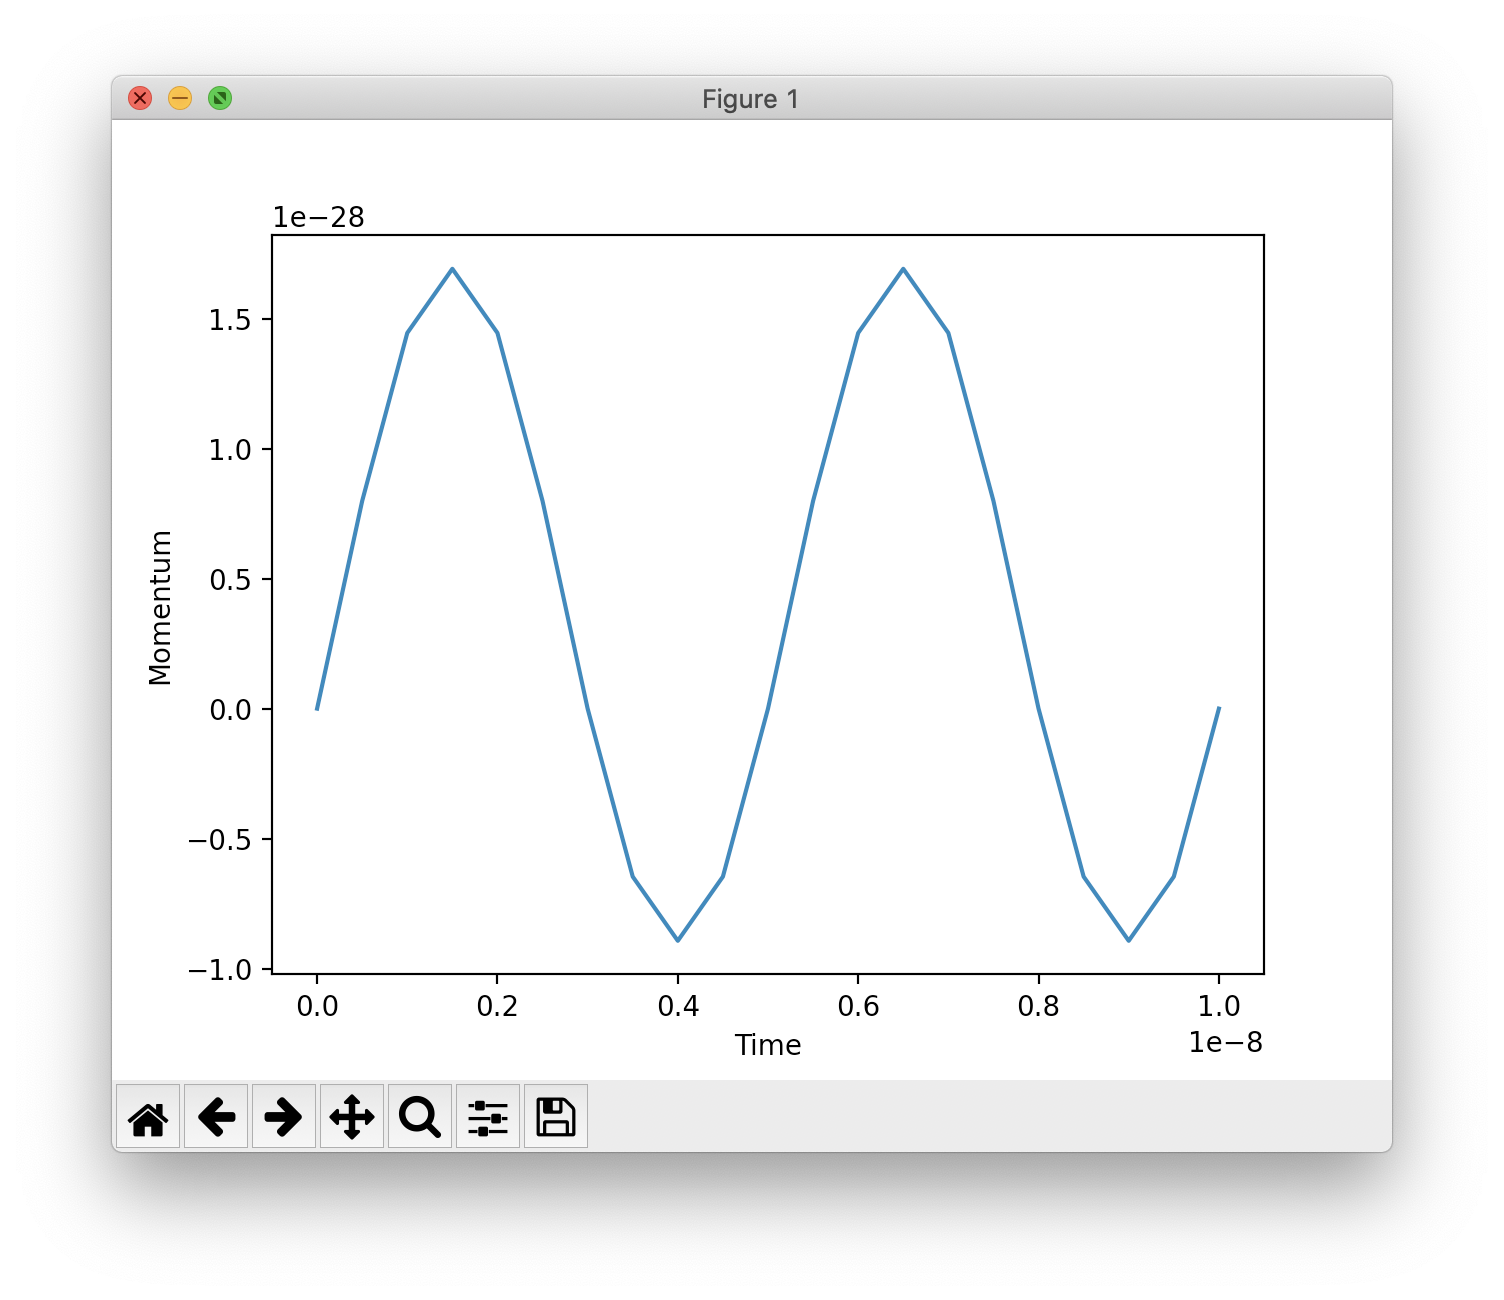

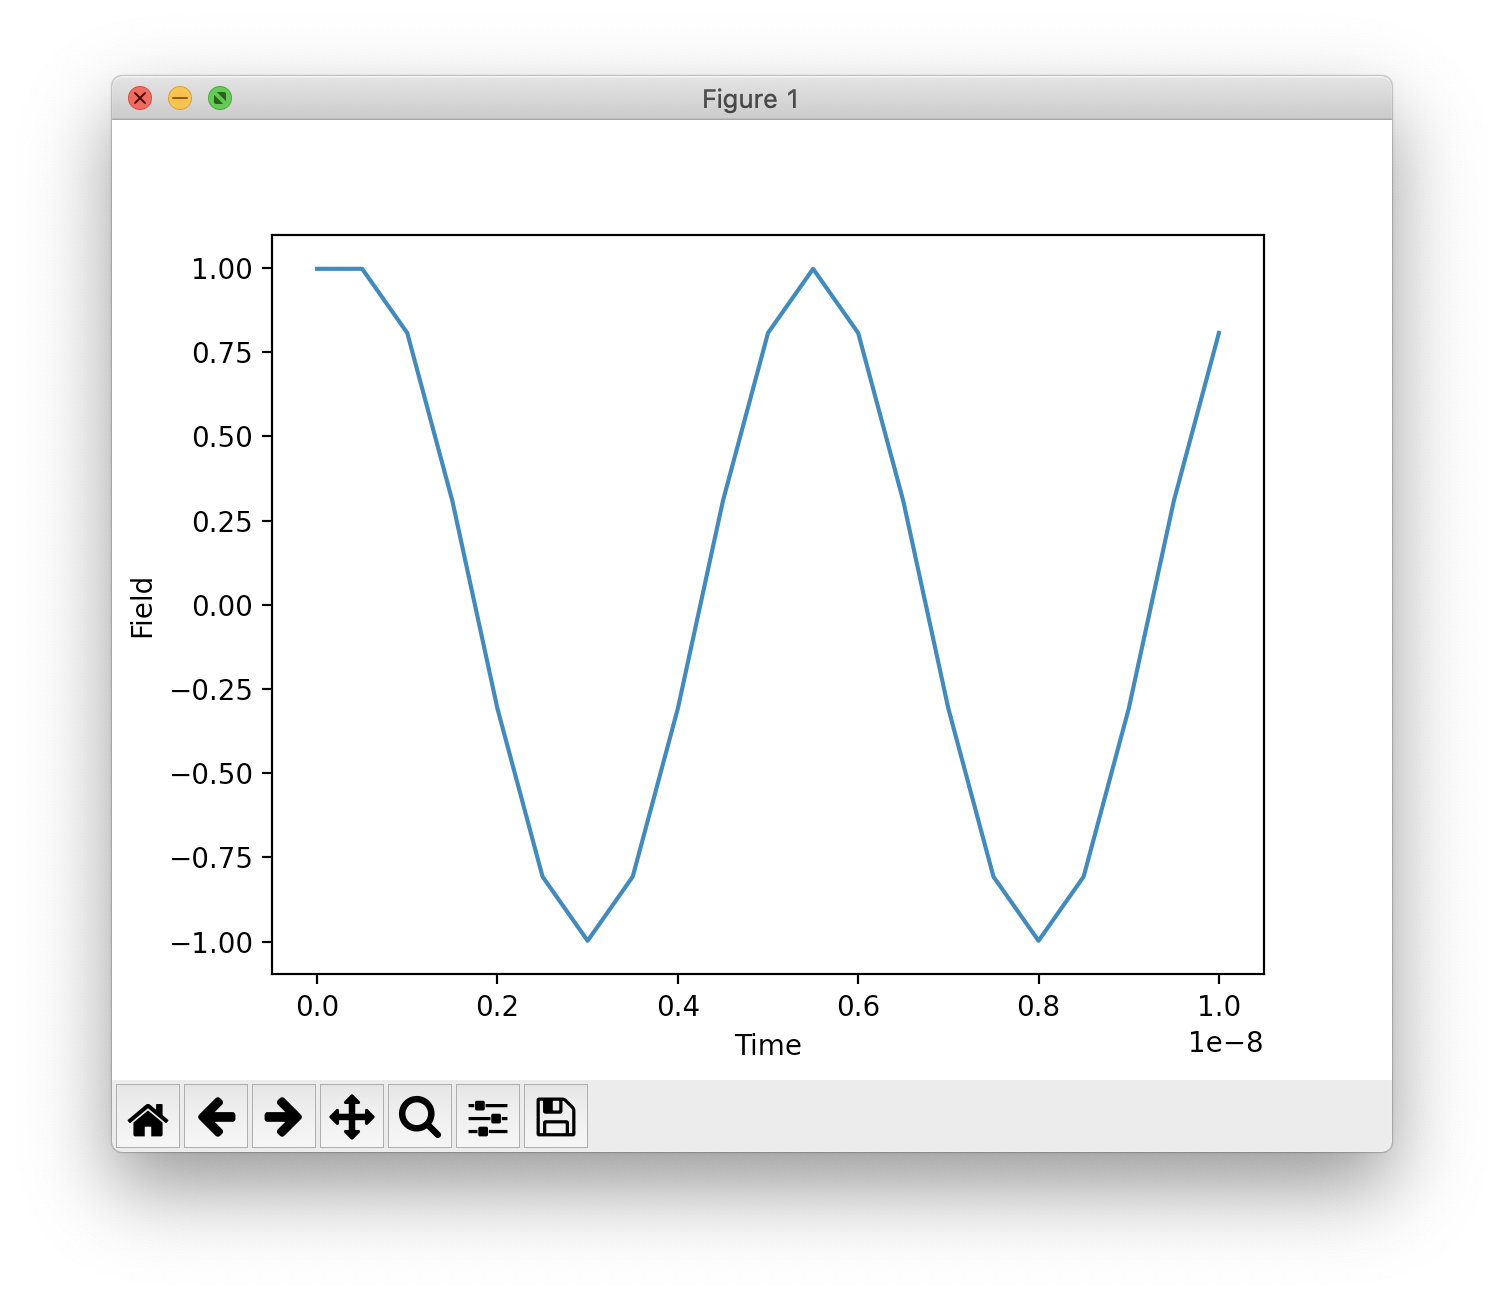

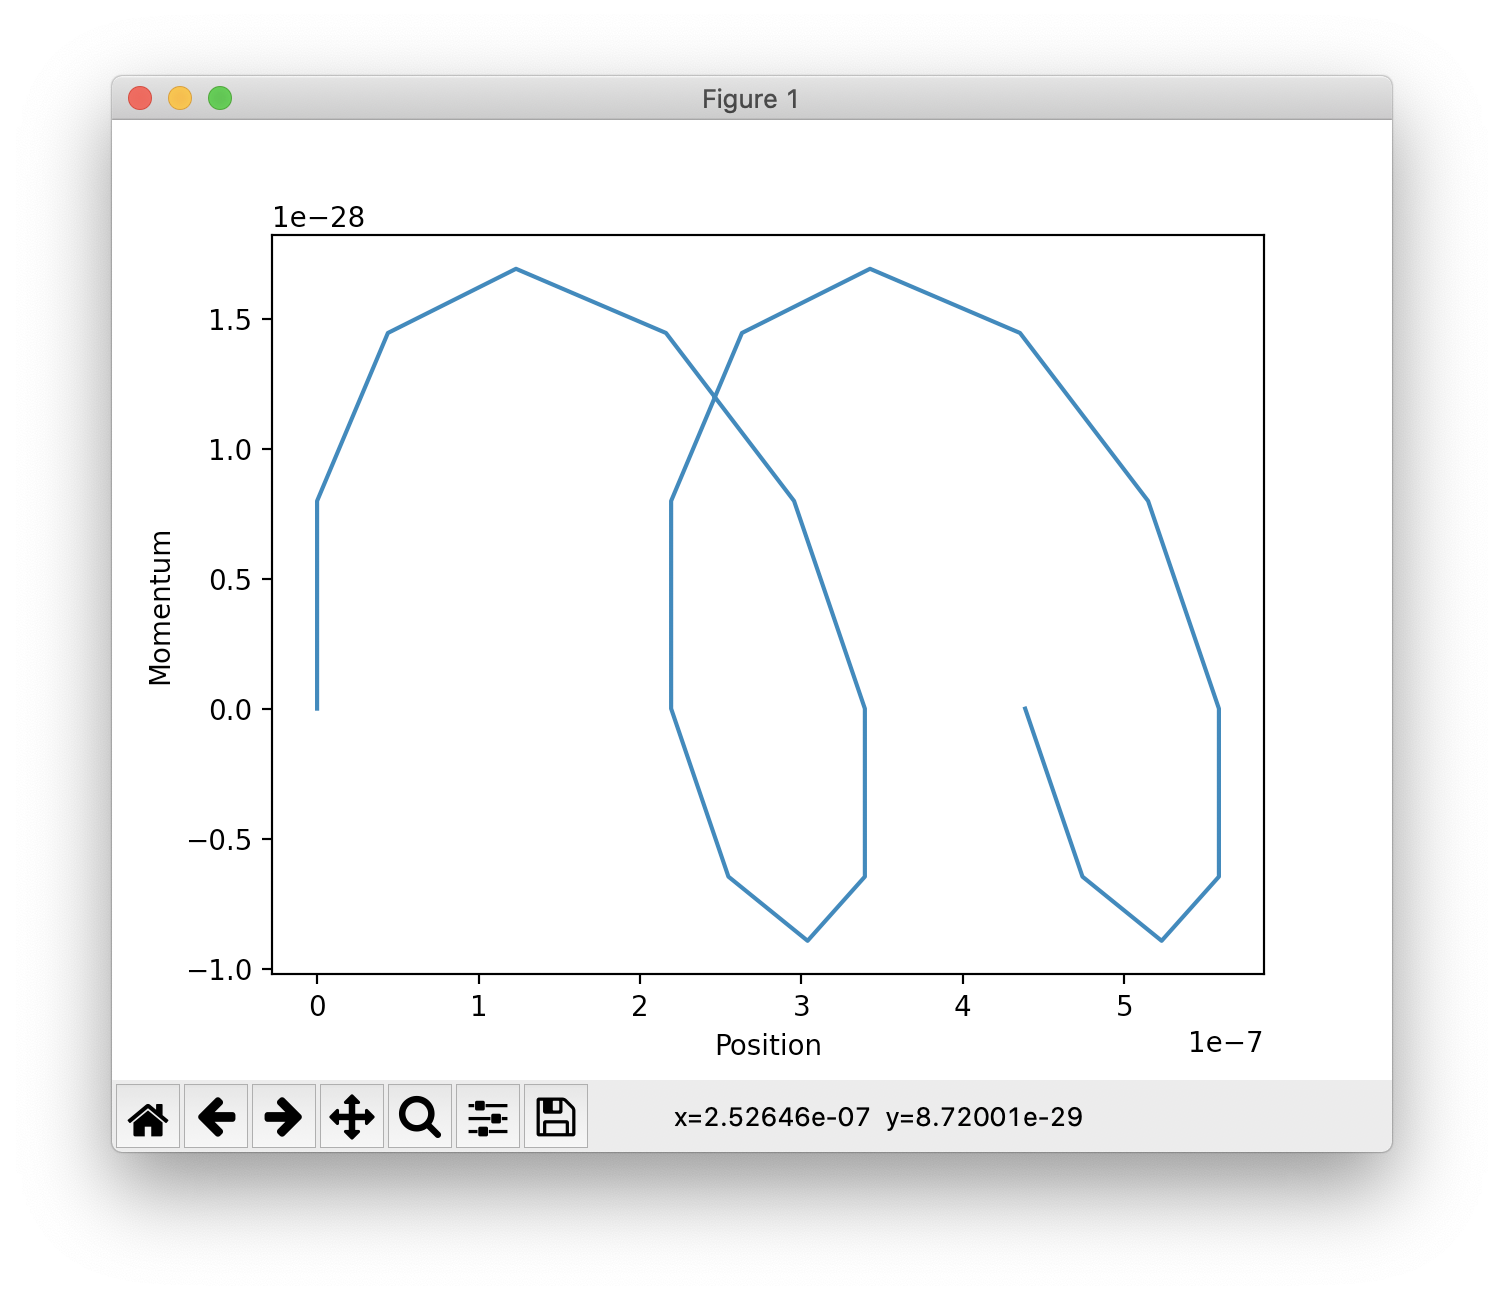